## 정확도(accuracy)

정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

정확도는 직관적이지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있음

In [1]:
#타이타닉 생존자를 아무런 학습 없이 단지 성별에 따라 생존자를 예측하는 단순한 Classifier 코드

from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    #fit()은 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    #predict()는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [2]:
from sklearn import preprocessing

#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#데이터 가공, 학습/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도: 0.7877


단순한 알고리즘으로 예측하더라도 데이터 구성에 따라 정확도 높을 수 있으므로 정확도를 평가지표로 사용할 때는 신중해야함

특히 불균형한 레이블 값 분포에서 모델 성능 평가하는 경우, 정확도는 적합하지 X

In [4]:
#MNIST 데이터 셋을 레이블 값이 7인 것만 True, 나머지는 False로 변환해 multi classification 에서 binary classification으로 변환
#즉 10%만 True, 나머지는 False -> 모든 데이터를 0으로 예측하는 모델의 정확도는 90% -> 불균형한 레이블 데이터 세트에서는 정확도 사용 X

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(sel, X, y):
        pass
    
    #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
#사이킷런의 내장 데이터인 load_digits() 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#DummyClassifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.900


## 오차행렬(confusion matrix, 혼동행렬)

4분면 행렬에서 실제 레이블 값과 예측 레이블 값 유형에 따라 TN, FP, FN, TP

앞 T/F는 예측 값과 실제 값이 같은 지 다른 지, 뒤 N/P는 예측 결과 값이 부정(0)인지 긍정인지(1)

In [5]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

array[0,0] : TN, array[0,1] : FP, array[1,0] : FN, array[1,1] : TP

MyFakeClassifier은 무조건 Negative 0으로 예측하는 Classifier - Negative 0으로 예측해서 True인 경우 405건, Negative 0으로 예측해서 False인 경우 45건

정확도 = (TN+TP)/(TN+FP+FN+TP)

보통 불균형한 이진분류 데이터 세트는 적은 수의 결괏값에 Positive 1 부여, 아니면 Negative 0 부여

Negative로 예측할 때 TN 매우 커지고 TP, FN, FP 매우 작아짐. 따라서, Negative에 대한 예측 정확도만으로 분류의 정확도가 높아지는 오류 발생

## 정밀도와 재현율

Positive 데이터 세트의 예측 성능에 초점을 맞춘 평가 지표

정밀도 = TP / (FP + TP) : 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율(양성 예측도)
- 재현율이 중요 지표인 경우: 실제 Positive 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 예) 암 판단 모델, 금융 사기 적발 모델

재현율 = TP / (FN + TP) : 실제 값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율(민감도, True Positive Rate)
- 정밀도가 중요 지표인 경우: 실제 Negative 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 예) 스팸 메일 여부

둘 다 TP를 높이는데 초점을 맞추지만 재현율은 FN 낮추는데, 정밀도는 FP 낮추는데 초점 - 상호보완적

In [6]:
#정밀도 : precision_score(), 재현율 : recall_score()

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터 재로딩, 데이터 가공, 학습/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


c:\python375\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


사이킷런 0.22 버전에서는 default solver가 'liblinear’ 에서 ‘lbfgs’ 로 변경되면서 경고 발생. max_iter 값 늘리기

### 정밀도/재현율 트레이드오프

분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음, 둘은 상호 보완적이므로 한 쪽 높이면 다른 쪽 낮아짐 - tradeoff

predict_proba(test 데이터) : 개별 클래스 예측 확률 반환, ndarray m*n (m:입력 값의 레코드 수, n:클래스 값 유형)형태로 반환, 각 열은 개별 클래스의 예측 확률

In [8]:
#이진 분류면 첫번째 칼럼이 0에 대한 예측 확률, 두번째 칼럼이 1에 대한 예측 확률
pred_proba = lr_clf.predict_proba(X_test)
print('predict_proba()의 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 추출')
print(pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한 눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두개의 class중에서 더 큰 클래스 값으로 예측됨')
print(pred_proba_result[:3])

predict_proba()의 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 추출
[[0.46172445 0.53827555]
 [0.87862224 0.12137776]
 [0.87724968 0.12275032]]
두개의 class중에서 더 큰 클래스 값으로 예측됨
[[0.46172445 0.53827555 1.        ]
 [0.87862224 0.12137776 0.        ]
 [0.87724968 0.12275032 0.        ]]


predict()는 predict_proba()의 결과 배열에서 분류 결정 임계값보다 큰 값이 들어있는 칼럼의 위치를 받아서 최종적으로 예측 클래스 결정

In [9]:
#이것을 코드로 구현 - Binarizer 이용(fit_transform(ndarray): ndarray의 값이 threshold보다 같거나 작으면 0, 크면 1 반환)
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold 값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [10]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임계값임
custom_threshold = 0.5

#predict_proba() 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [11]:
#Binarizer의 threshold 설정값 0.4로 설정, 분류 설정 임계값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임계값 낮췄더니 정밀도 감소, 재현율 증가 - True 값이 많아지게 되므로 재현율 값 높아짐, 양성 예측을 많이 하여서 실제 양성을 음성으로 예측하는 횟수 상대적으로 감소

In [12]:
#테스트를 수행할 모든 임곗값을 리스트 객체에 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print()
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 : 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361

임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033

임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541

임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377



In [13]:
#위와 유사한 API: precision_recall_curve(실제 클래스값 배열, Positive 예측 확률 배열) -> 임곗값별 정밀도, 재현율 값을 배열로 반환
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 4))

#15step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 - 임계값 증가할수록 정밀도 증가, 재현율 감소
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1039 0.1214 0.1403 0.1866 0.2806 0.4039 0.5649 0.667  0.8221 0.9473]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


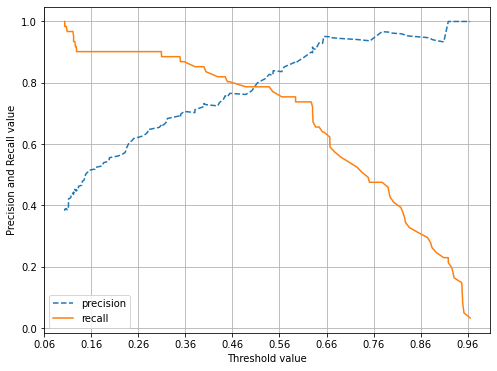

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행, 점밀도는 점선으로
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### 정밀도와 재현율의 맹점

정밀도 또는 재현율 중 하나에 상대적인 중요도를 부여해 각 상황에 맞게 알고리즘 튜닝할 수 있지만, 하나를 극단적으로 높이면 안됨.

정밀도와 재현율의 수치가 적절하게 조합되어야 분류의 종합적인 성능 평가 가능

## F1 스코어

정밀도와 재현율을 결합한 지표, 둘 중 어느 쪽으로 치우치지 않을 때 F1 스코어 값이 상대적으로 높음

F1 = 2 * (precision * recall) / (precision + recall)

In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [16]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    #F1 score print도 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 : 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786

임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840

임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805

임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931

임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036



## ROC 곡선과 AUC

ROC곡선과 그에 기반한 AUC score은 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표

ROC 곡선(Receiver Operation Characteristic Curve): FPR이 변할 때 TPR(재현율)이 어떻게 변하는지를 나타내는 곡선, FPR을 X축으로 TPR을 Y축으로
- TPR(True Positive Rate): 재현율, 재현율은 민감도로도 불림, 실제값 Positive가 정확히 예측되어야 하는 수준
    - TPR = TP / (FN + TP)

- 민감도에 대응하는 지표로 TNR(True Negative Rate)이라고 불리는 특이성이 있음, 실제값 Negative가 정확히 예측되어야 하는 수준
    - TNR = TN / (FP + TN)

- FPR(False Positive Rate) = FP / (FP + TN) = 1 - TNR = 1 - 특이성

ROC 곡선은 FPR을 0에서 1까지 변경하면서 TPR의 변화값 구함

FPR 값 변경하려면 분류 결정 임계값 변경하면 됨.
- FPR 0 : 임계값 1
    - 임계값 1로 지정하면 Positive 기준이 높아서 Positive로 예측할 수 없음, FP 값 0이 되므로 FPR도 0

- FPR 1 : 임계값 0
    - 임계값 0으로 지정하면 Positive 기준이 낮아서 다 Positive로 예측, TN 값 0이 되므로 FPR은 1

In [17]:
#roc_curve(실제 클래스 값, predict_proba()반환 값 중 Positive 칼럼) -> fpr, tpr, thresholds 값 array로 반환
from sklearn.metrics import roc_curve

#레이블 값이 1일때의 예측확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임계값 배열에서 샘플로 데이터 추출하되, 임계값을 5step으로 추출
#thresholds[0]: max(예측확률+1)로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 4))

#5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값: [0.9651 0.6543 0.6303 0.5942 0.4886 0.3994 0.3096 0.1478 0.1228 0.112
 0.1039]
샘플 임계값별 FPR: [0.    0.017 0.034 0.059 0.127 0.161 0.237 0.483 0.61  0.703 0.814]
샘플 임계값별 TPR: [0.033 0.639 0.705 0.754 0.787 0.852 0.885 0.902 0.934 0.967 0.984]


임계값이 1에 가까운 값에서 작아질수록 FPR 커짐. FPR 조금씩 커질 때, TPR은 가파르게 커짐

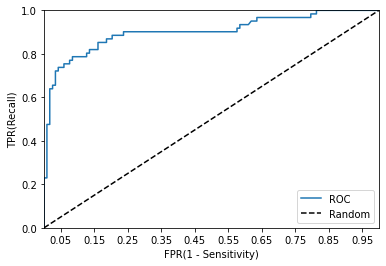

In [18]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    #FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

왼쪽 하단과 오른쪽 상단을 대각선으로 이은 직선은 ROC 곡선의 최저값, 랜덤 수준의 이진 분류의 ROC 직선(AUC = 0.5)

ROC 곡선이 이 직선에 가까울수록 성능 떨어짐, 멀어질수록 성능 뛰어남

ROC 곡선은 FPR, TPR의 변화 값 보는 데 이용, 분류 성능 지표로 사용되는 것은 ROC 곡선 밑의 면적인 AUC 값(예측 확률값을 기반으로)

AUC가 1에 가까울 수록 좋은 수치: 작은 FPR에서 얼마나 큰 TPR을 구할 수 있는지가 관건, 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 이동하는 직사각형에 가까운 곡선인 경우

In [19]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [20]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print()

get_eval_by_threshold(y_test, pred_proba.reshape(-1,1), thresholds)

임계값 : 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786, AUC: 0.9024

임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840, AUC: 0.9024

임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805, AUC: 0.9024

임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931, AUC: 0.9024

임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036, AUC: 0.9024

